# Exercise 

In this exercise, we will learn how to compute the spectra of the adjacency matrix by using the the karate club network. 

In [27]:
import numpy as np
from scipy import sparse
import networkx as nx
import igraph

G = nx.karate_club_graph()
A = nx.to_scipy_sparse_array(G).asfptype()
A.data = A.data * 0 + 1  # binarlize

src, trg, _ = sparse.find(sparse.triu(A, 1))
g = igraph.Graph(tuple(zip(src, trg)), directed=False)

labels = np.unique([d[1]["club"] for d in G.nodes(data=True)], return_inverse=True)[1]

Let us visualize the network

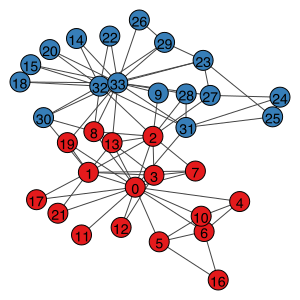

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

ulabels, indices = np.unique(labels, return_inverse=True)
node_colors = sns.color_palette("Set1", len(ulabels))
node_colors = [node_colors[i] for i in indices]

igraph.plot(
    g,
    vertex_color=node_colors,
    vertex_label=np.arange(A.shape[0], dtype=int),
    bbox=(300, 300),
)

Let's compute the spectra of the adjacency matrix by 

In [31]:
lam, U = sparse.linalg.eigs(A, k=5, which="LM")

# Let's print out the matrix U

`scipy.linalg.eigs` produces complex-valued eigenvectors and eigenvalues. When matrix $A$ is symmetric, the eigenvalues and eigenvectors are always real-valued, which is indeed the case for our analysis. Thus, we should take only the real part of these numbers. You can do this by using `np.real`. 

In [34]:
U = ...  # convert to real-valued numpy
lam = ...  # convert to real-valued numpy

Let's see the eigenvectors in a heatmap:

<Axes: >

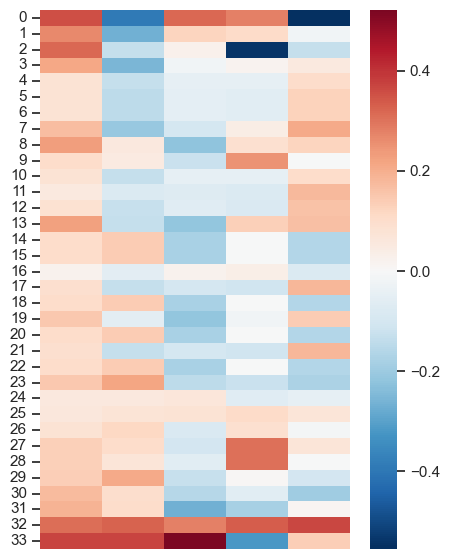

In [40]:
sns.set_style("white")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(5, 7))

sns.heatmap(U, cmap="RdBu_r", center=0, xticklabels=False, yticklabels=True)

The left most column corresponds to the principal eigenvector (or eigencentrality). Other embedding captures the community structure of the network. 
To see this, let's visualize the eigencentrality in the node-link diagram with igraph. 

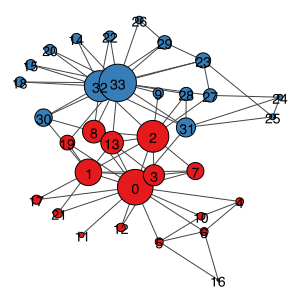

In [43]:
igraph.plot(
    g,
    vertex_color=node_colors,
    vertex_size=...,  # set the vertex size to be proportional to the eigenvector
    vertex_label=np.arange(A.shape[0], dtype=int),
    bbox=(300, 300),
)

Now, let's visualize the second and third eigenvectors by using a scatter plot. 

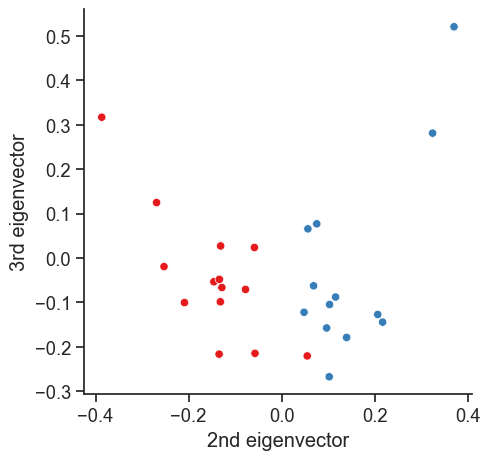

In [49]:
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(
    x=...,  # set the x-axis to be the second eigenvector
    y=...,  # set the y-axis to be the thrid eigenvector
    color=node_colors,
)
ax.set_xlabel("2nd eigenvector")
ax.set_ylabel("3rd eigenvector")
sns.despine()

What does the eigenvalue tell us? It is an importance of each embedding dimension in terms of the matrix reconstruction. Let's see the raw values. 

In [51]:
lam

array([ 6.72569773,  4.97707423, -4.48722919, -3.44793486, -3.11069092])

The values are in descending order of the magnitude. The left-most eigenvector, or principal eigenvector, is the most important vector to reconstruct the adjacency matrix, followed by the second and third eigenvectors that capture the community structure in networks.  

The original adjacency matrix can be reconstructed by using the embedding. To see this, let's generate $N$ dimensional embedding, where $N$ is the number of nodes. Since it contains all spectrum, the adjacency matrix should be exactly reconstructed.  

In [104]:
lam, U = np.linalg.eig(
    A.toarray()
)  # We will use numpy.linalg.eig for a full eigendecomposition

order = np.argsort(-np.abs(lam))
lam, U = lam[order], U[:, order]  # Sort the eigenvalues and eigenvectors by magnitude

U = np.real(U)

V = A @ U  # Construct the other embedding

# Reconstruct the adjacency matrix
Ahat = U @ V.T

<Axes: >

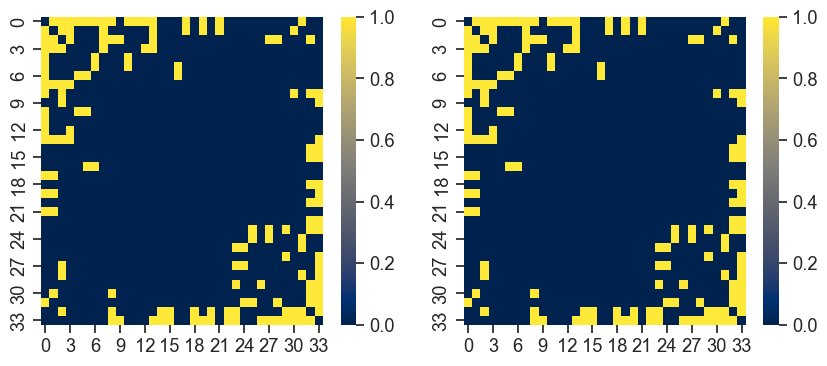

In [105]:
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)

sns.heatmap(A.toarray(), ax=axes[0], cmap="cividis")
sns.heatmap(Ahat, ax=axes[1], cmap="cividis")

The adjacency matrix is precisely reconstructed with the embedding. Now, let's drop bottom 5 eigenvectors with the smallest eigenvalues in magnitude. 

<Axes: >

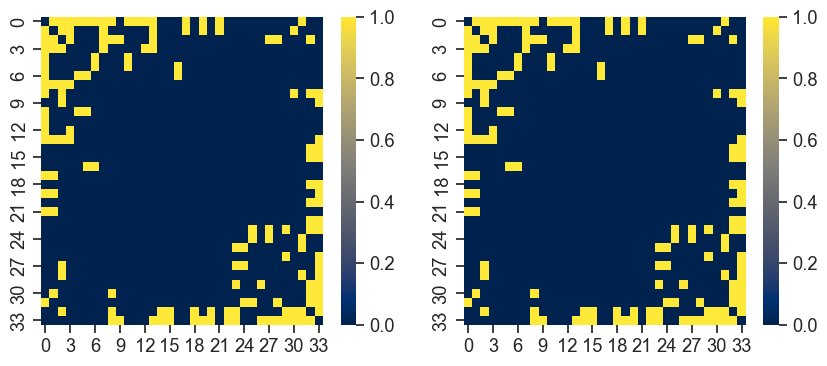

In [106]:
# Reconstruct the adjacency matrix
Ahat = U[:, :-5] @ V[:, :-5].T

sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)

sns.heatmap(A.toarray(), ax=axes[0], cmap="cividis")
sns.heatmap(Ahat, ax=axes[1], cmap="cividis")

Can you find any difference? How about dropping the top five eigenvectors associated with the largest eigenvalues?

ValueError: Must pass 2-d input. shape=()

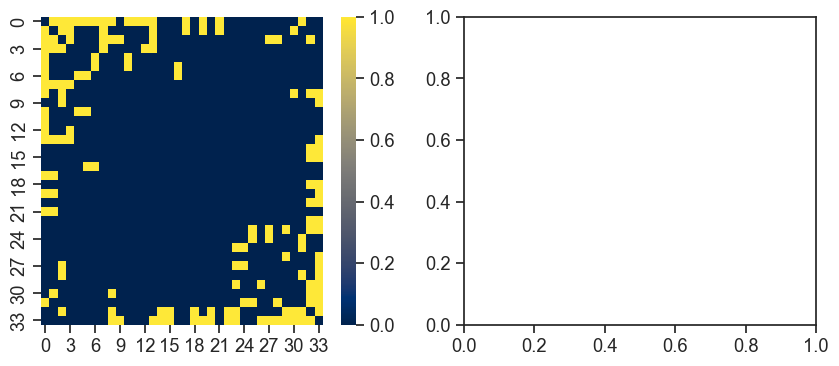

In [107]:
# Reconstruct the adjacency matrix
Ahat = ...  # construct the adjacency matrix by yourself

sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)

sns.heatmap(A.toarray(), ax=axes[0], cmap="cividis")
sns.heatmap(Ahat, ax=axes[1], cmap="cividis")

You should be able to spot the differences between the original and reconstructed adjacency matrix more easily this time. In fact, the matrix can be reconstructed well without the bottom eigenvectors with small eigenvalues in magnitude. However, missing few top eigenvectors can lead to a substantial reconstruction error. 

Let's confirm it quantitatively by computing the reconstruction error. 

In [108]:
V = A @ U

Ahat = U[:, :-5] @ V[:, :-5].T
error = np.sum((A.toarray() - Ahat) ** 2) / 2
print(f"Reconstruction error without the bottom 5 eigenvectors: {error:e}")

Ahat = U[:, 5:] @ V[:, 5:].T
error = np.sum((A.toarray() - Ahat) ** 2) / 2
print(f"Reconstruction error without the bottom 5 eigenvectors: {error:e}")

Reconstruction error without the bottom 5 eigenvectors: 2.750529e-28
Reconstruction error without the bottom 5 eigenvectors: 5.585308e+01


🚨🚨Math Alert🚨🚨

For those with math phovia, just take a breath. Just take the first two lines text which are sufficient to complete the assignment.  

The reconstruction error and eigenvalues are tightly related as follows:
$$
\text{Error} = \frac{1}{2}\left(\sum_{i,j}A_{ij}^2 - \sum_{k=1}^K \lambda^2\right)
$$ 

(For those without math phovia, the following is optional, though, I believe that it is a good exercise to be a friend with spectral decomposition. It appears virtually every corner of science and engineering, and highly useful for so many things. It is definitely a good time investment, I believe.)

This is because of the following reasons. Denoted by $U$ and $V$ the eigenvectors of the matrix $X$, and $\Lambda$ be the diagonal matrix with diagonal entries $D_{kk}$ being the eigenvalue $\lambda_k$.
Geometrically speaking $U$ is a rotation matrix for $N$ dimensional space ($N$ is the number of nodes). Since it just rotates the space, it does not shrink or expand the space, i.e., the length is preserved. Therefore, 
$$
J = \frac{1}{2} || A - \hat A||_2^2 = \frac{1}{2} || U^\top (A - \hat A) U||_2^2.
$$ 
In fact

In [109]:
error = np.sum((A - Ahat) ** 2) / 2
error_with_rotation = np.sum((U.T @ (A - Ahat) @ U) ** 2) / 2
print(f"Reconstruction error: {error:e} (with rotation: {error_with_rotation:e})")

Reconstruction error: 5.585308e+01 (with rotation: 5.585308e+01)


Now, let's consider using the top $K$ eigenvectors associated with the largest eigenvalues in magnitude. Denoted by $\hat U$ and $\hat V$ the left and right eigenvectors, which are $K$ dimensional. And denoted by $\hat \Lambda$ the corresponding eigenvalue matrix. The reconstructed matrix $\hat A$ is given by 
$$
\hat A = \hat U  \hat \Lambda  \hat V
$$
And the eigenvectors are orthogonal to each other ($\hat U^\top \hat U = I$ and $\hat U^\top \hat V = I$). Thus, we have
$$
\hat U^\top \hat A \hat U = \hat \Lambda
$$
In fact

<Axes: >

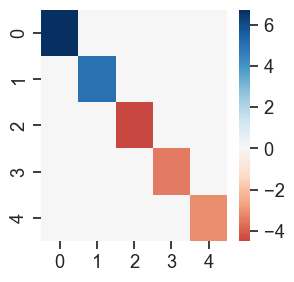

In [122]:
K = 5
lam, V = np.linalg.eig(A.toarray().T)
V = np.real(V)
lam = np.real(lam)

Uhat = U[:, :K]
Vhat = V[:, :K]
lamhat = lam[:K]
Ahat = Uhat @ np.diag(lamhat) @ Vhat.T

sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(Uhat.T @ A @ Uhat, cmap="RdBu", center=0, ax=ax)

The bottom eigenvectors not included in $\hat U$ are orthogonal to $\hat U$. Thus, we have  
$$
U^\top \hat A U = \text{diag}(\lambda_1,\ldots, \lambda_K, 0,\ldots, 0) 
$$
(Note that it's $U$ not $\hat U$). In fact

<Axes: >

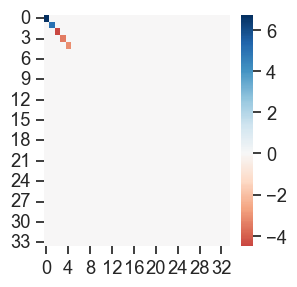

In [125]:
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(U.T @ Ahat @ U, cmap="RdBu", center=0, ax=ax)

Altogether, 
$$
\begin{align}
J &= \frac{1}{2} || A - \hat A||_2^2 \\
& = \frac{1}{2} || U^\top (A - \hat A) U||_2^2 \\
&= \frac{1}{2} || U^\top A U - U^\top \hat A U||_2^2 \\
&= \frac{1}{2} || \text{diag}(\lambda_1, \lambda_2,\ldots, \lambda_N) - \text{diag}(\lambda_1,\ldots, \lambda_K, 0, \ldots, 0)||_2^2 \\
&= \frac{1}{2}\sum_{k=k+1}^n \lambda_k ^2 \\
&= \frac{1}{2} \left( ||A||_2^2 - \sum_{k=1}^K \lambda_k ^2 \right)
\end{align}
$$ 
The last equation is derived from the fact $||A||_2^2 = \sum_{k=1}^N \lambda_k^2$.